In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
elif torch.backends.mps.is_available():
    dev = "mps"
else:
    dev = "cpu"
device = torch.device(dev)
device

device(type='cuda', index=0)

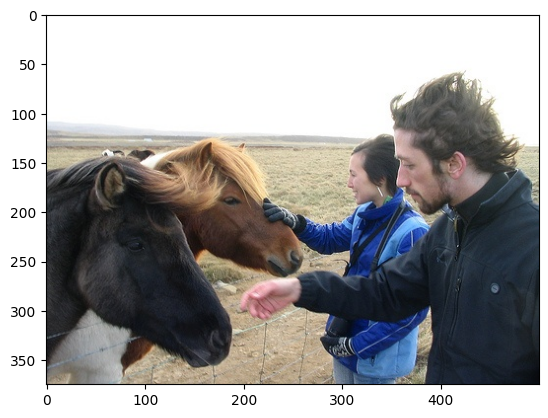

In [3]:
img = Image.open('./VOCdevkit/VOC2012/JPEGImages/2007_004902.jpg').convert("RGB")
plt.imshow(img)

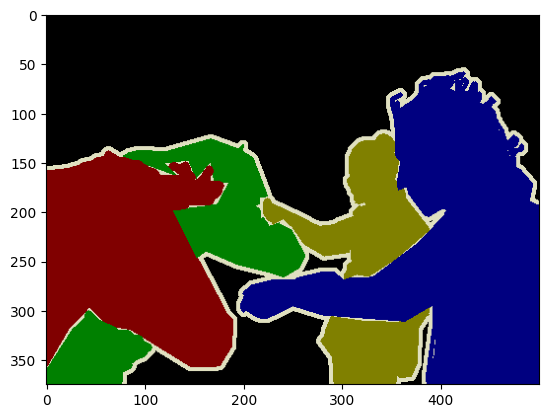

In [4]:
mask = Image.open('./VOCdevkit/VOC2012/SegmentationObject/2007_004902.png')
plt.imshow(mask)

SegmentationObject masks are instance-aware masks. It can be loaded from the directory VOC2012/SegmentationObject/. These are .png files where each instance has a unique grayscale value. Background is 0. All objects of the same class are separated into unique IDs.

In [5]:
class VOCDatasetSeg(torch.utils.data.Dataset):
    def __init__(self, image_set='train', transforms=None):
        self.image_set = image_set
        self.transforms = transforms

        split_file = f'VOCdevkit/VOC2012/ImageSets/Segmentation/{image_set}.txt'
        with open(split_file) as f:
            self.ids = [line.strip() for line in f.readlines()]

    def __getitem__(self, idx):
        image_id = self.ids[idx]
        img_path = f'./VOCdevkit/VOC2012/JPEGImages/{image_id}.jpg'
        mask_path = f'./VOCdevkit/VOC2012/SegmentationObject/{image_id}.png'

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[(obj_ids != 0) & (obj_ids != 255)]  # remove background and void label

        masks = mask == obj_ids[:, None, None]
        boxes = []
        labels = []

        # construct bounding boxes tightly wrapping the instance masks (instead of using original annotations)
        for i in range(len(obj_ids)):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmax <= xmin:
                xmax = xmin + 0.00001
            if ymax <= ymin:
                ymax = ymin + 0.00001
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # for simplicity here: use class 1 for all objects (can be expanded to true VOC class)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id_tensor = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(obj_ids),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id_tensor,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

In [6]:
# standard normalization values used for ImageNet models
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

In [7]:
input_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])

In [8]:
dataset = VOCDatasetSeg(image_set='train', transforms=input_transforms)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [9]:
# model = maskrcnn_resnet50_fpn_v2(weights=None, weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT, min_size=400)
model = maskrcnn_resnet50_fpn_v2(weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT, min_size=400)

# adjust for 2 classes (background + object)
num_classes = 2

# replace box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# replace mask predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to C:\Users\70p6229/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100.0%


In [10]:
params = [p for p in model.parameters() if p.requires_grad] # more efficient than including frozen parameters
optimizer = torch.optim.Adam(params, lr=1e-4)

In [11]:
epochs = 10

model.train()
for epoch in range(epochs):
    losses_epoch = 0
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        losses_epoch += losses.item()

    print(f"Epoch {epoch+1}, Loss: {losses_epoch:.4f}")

Epoch 1, Loss: 482.5243
Epoch 2, Loss: 366.0328
Epoch 3, Loss: 324.1819
Epoch 4, Loss: 284.9087
Epoch 5, Loss: 256.5143
Epoch 6, Loss: 249.2751
Epoch 7, Loss: 221.4274
Epoch 8, Loss: 210.3712
Epoch 9, Loss: 209.3286
Epoch 10, Loss: 206.8703


In [12]:
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(400,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [13]:
def plot_predictions_vs_targets(img_tensor, prediction, target, score_threshold=0.5):
    img_tensor = img_tensor.cpu() * torch.tensor(imagenet_std).view(3, 1, 1) + torch.tensor(imagenet_mean).view(3, 1, 1)
    img = to_pil_image(img_tensor.cpu())

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    target_masks = target['masks'].cpu()
    summed_target_masks = np.zeros_like(target_masks[0])
    num_instances_gt = 0
    for i, target_mask in enumerate(target_masks):
        summed_target_masks = np.add(summed_target_masks, target_mask)
        num_instances_gt += 1
    axs[1].imshow(summed_target_masks, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")
    axs[1].text(0.5, -10.0, f"# instances: {num_instances_gt}", fontsize=12)

    pred_masks = prediction['masks'].cpu()
    scores = prediction['scores'].cpu()
    summed_pred_masks = np.zeros_like(summed_target_masks)
    num_instances_pred = 0
    for i, pred_mask in enumerate(pred_masks):
        if scores[i] < score_threshold:
            continue
        pred_mask = pred_mask.squeeze() > 0.5
        summed_pred_masks = np.add(summed_pred_masks, pred_mask)
        num_instances_pred += 1
    axs[2].imshow(summed_pred_masks > 0., cmap='gray')
    axs[2].set_title("Prediction")
    axs[2].axis("off")
    axs[2].text(0.5, -10.0, f"# instances: {num_instances_pred}", fontsize=12)

    plt.tight_layout()
    plt.show()

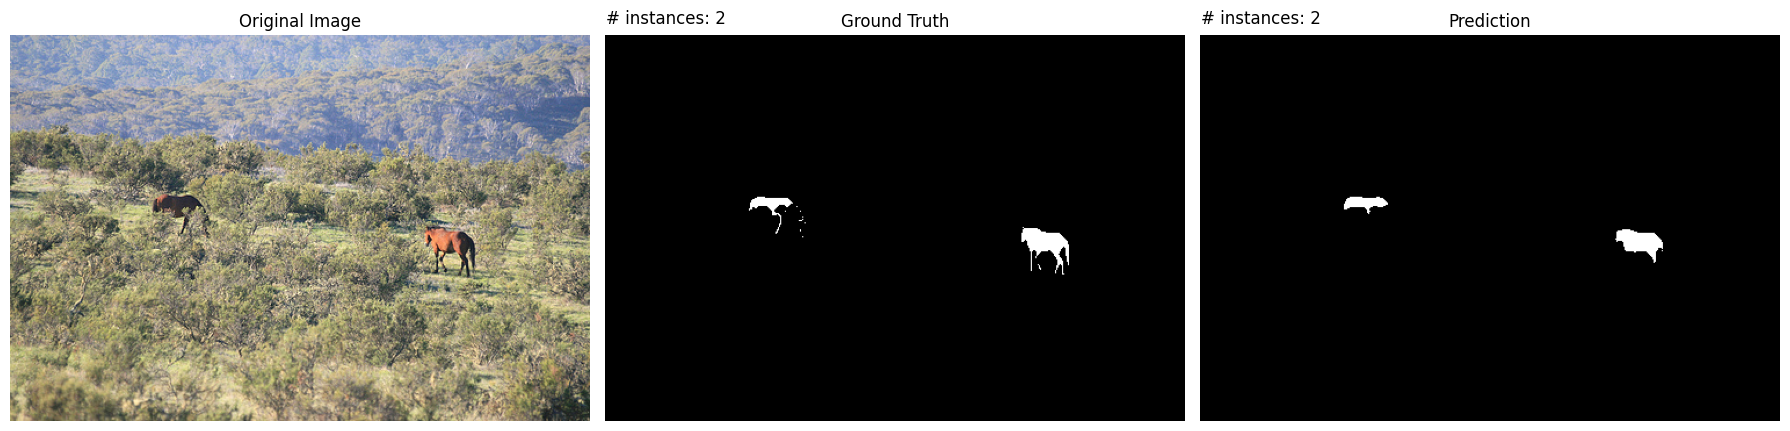

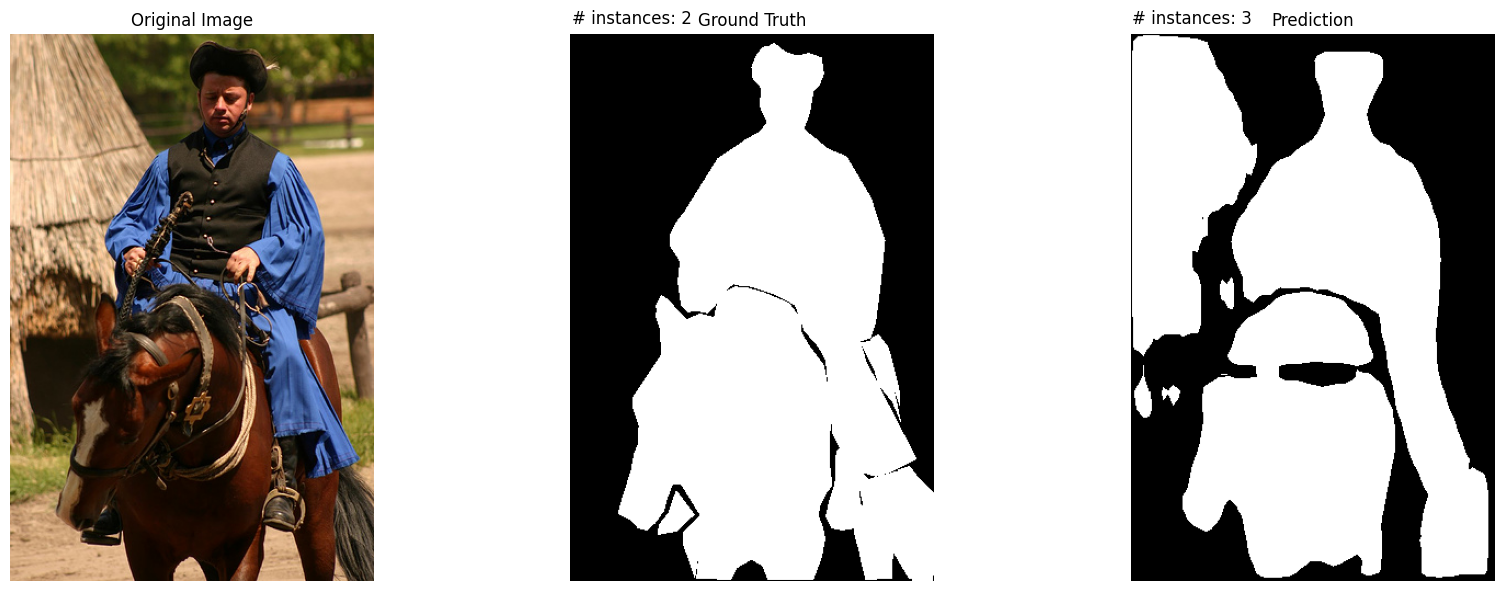

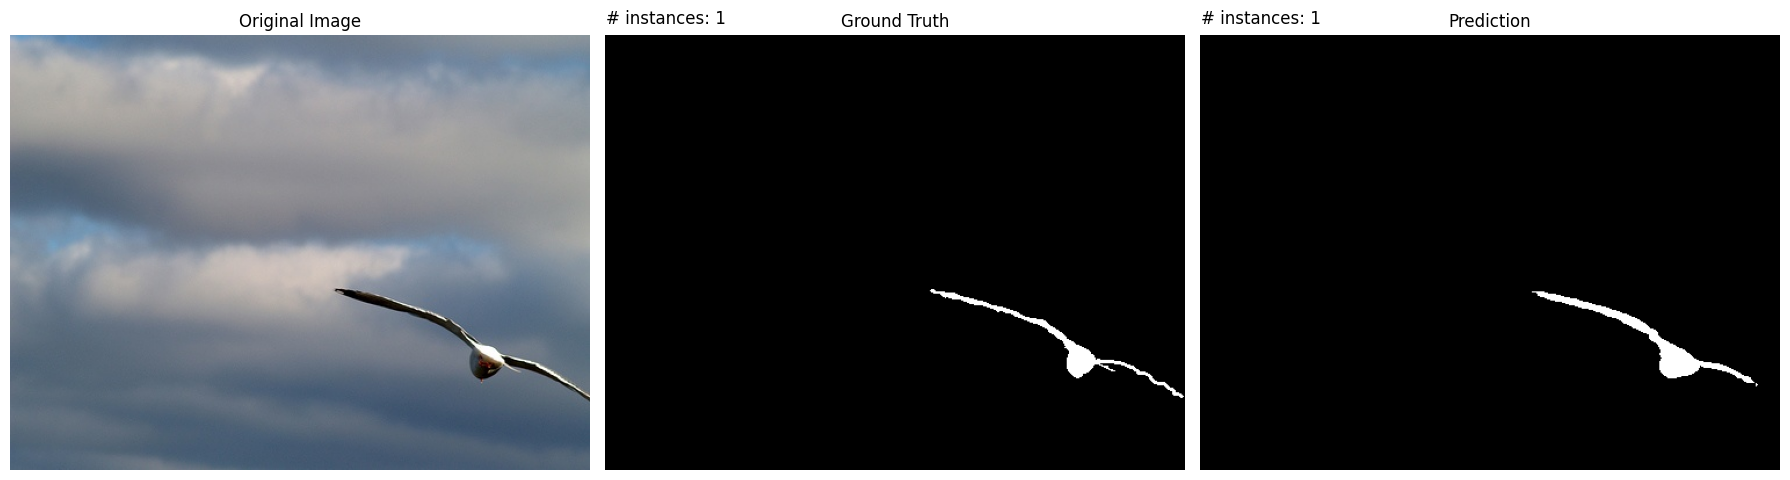

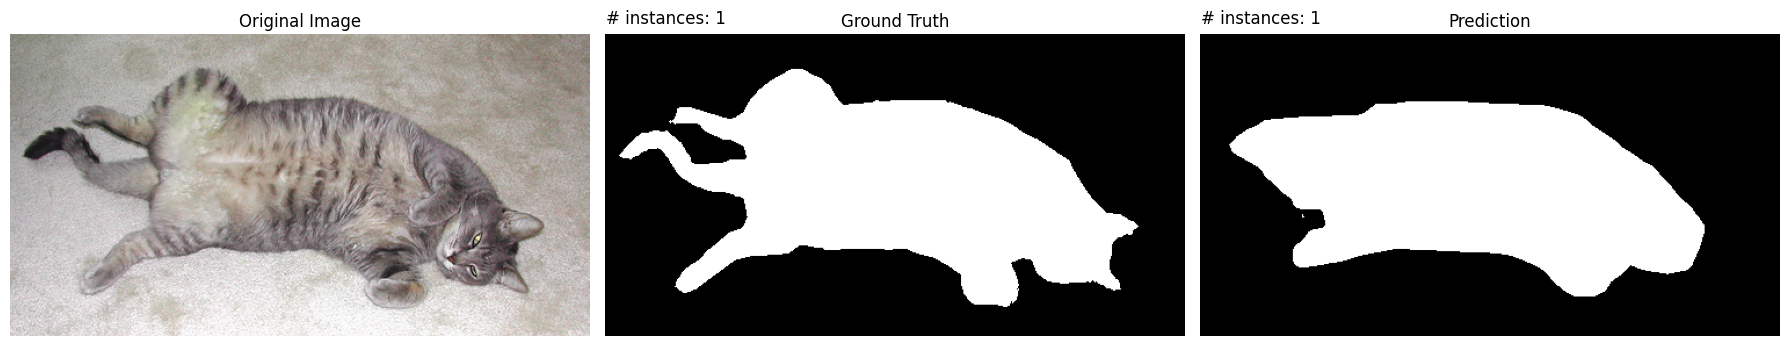

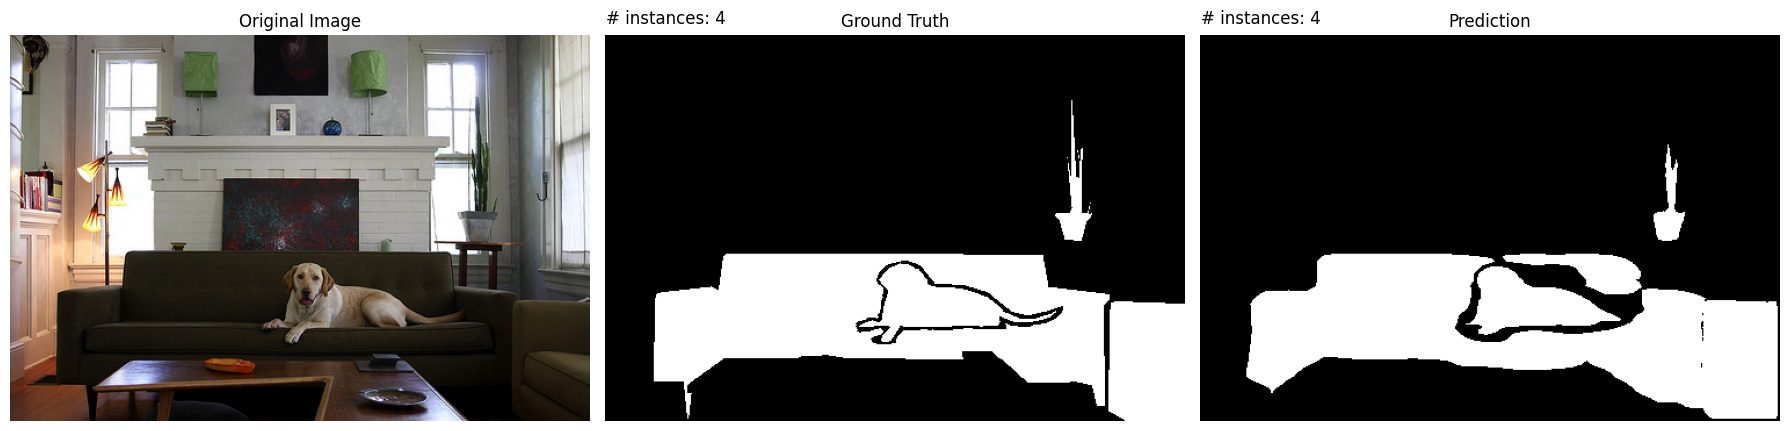

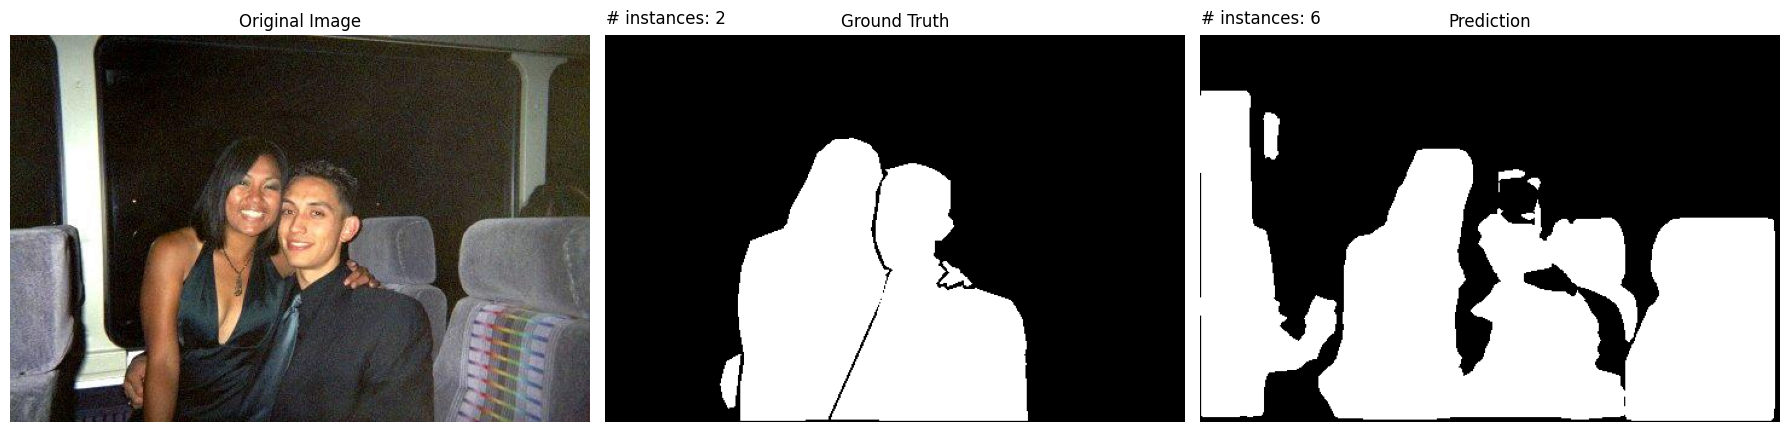

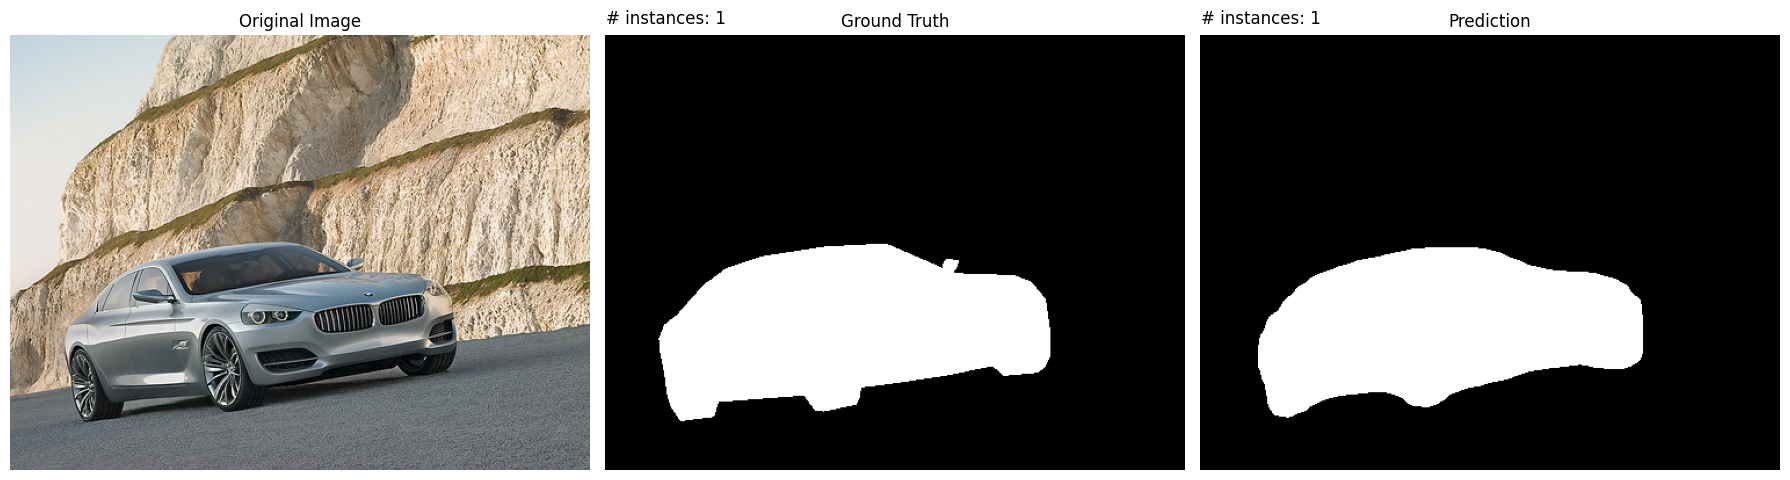

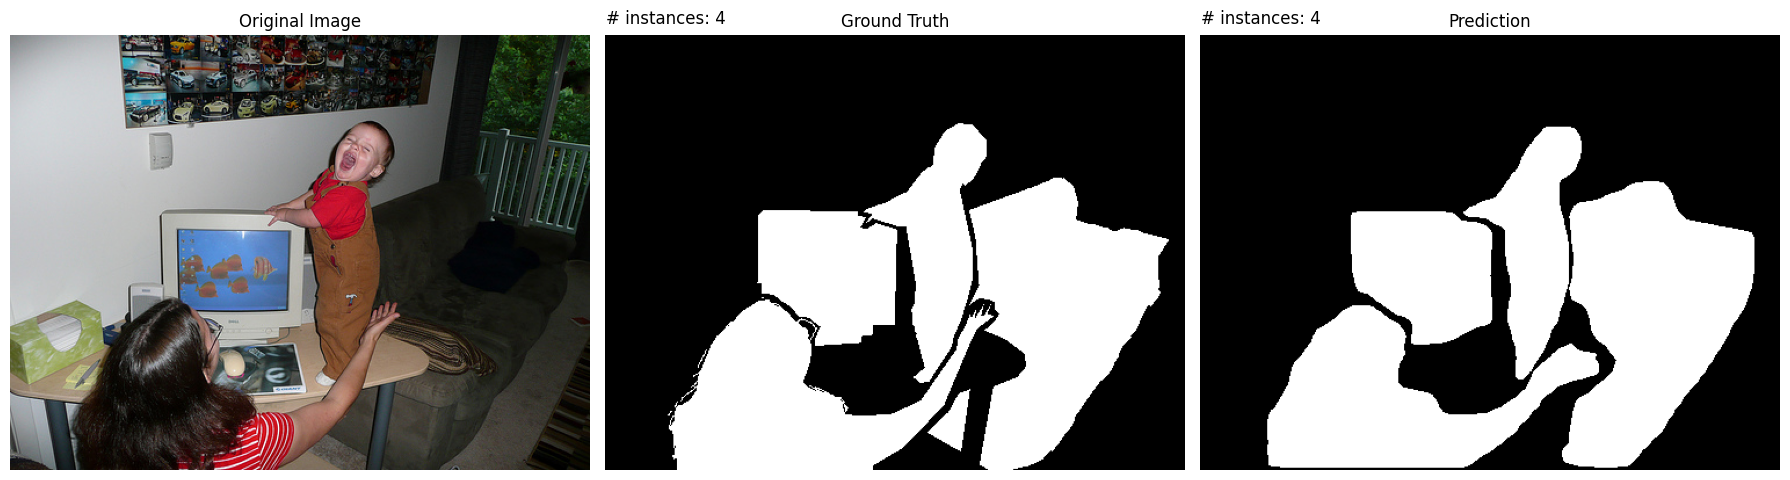

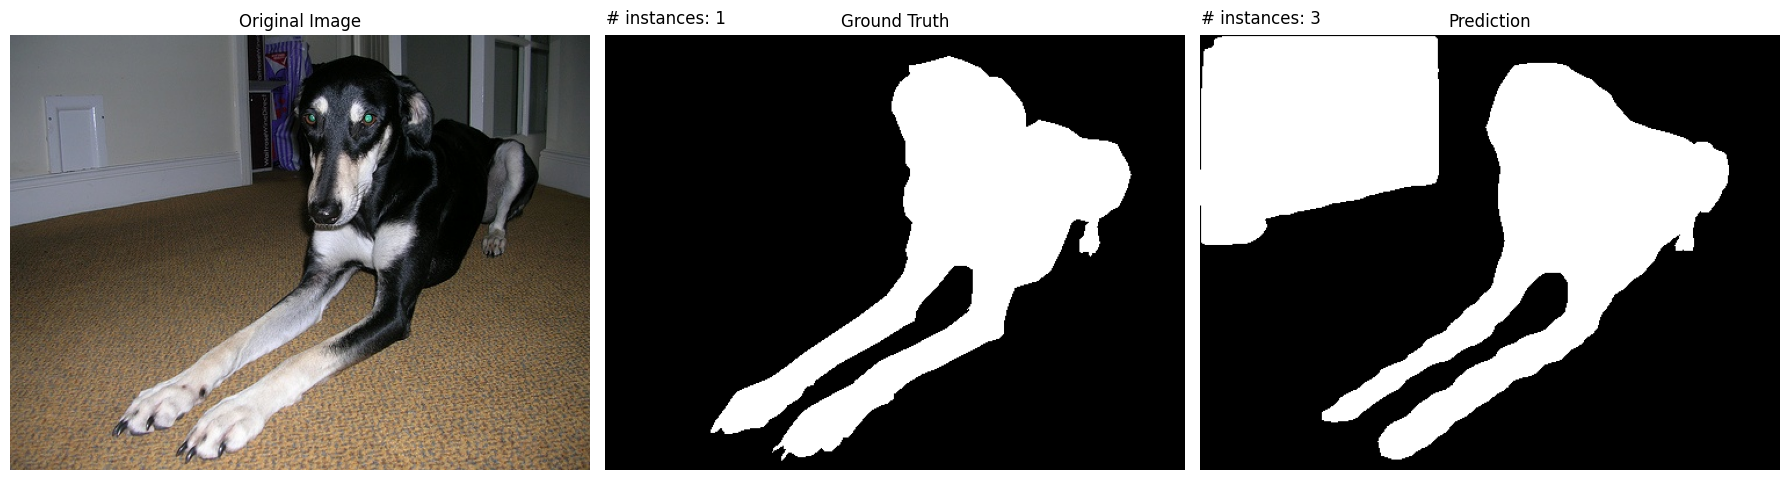

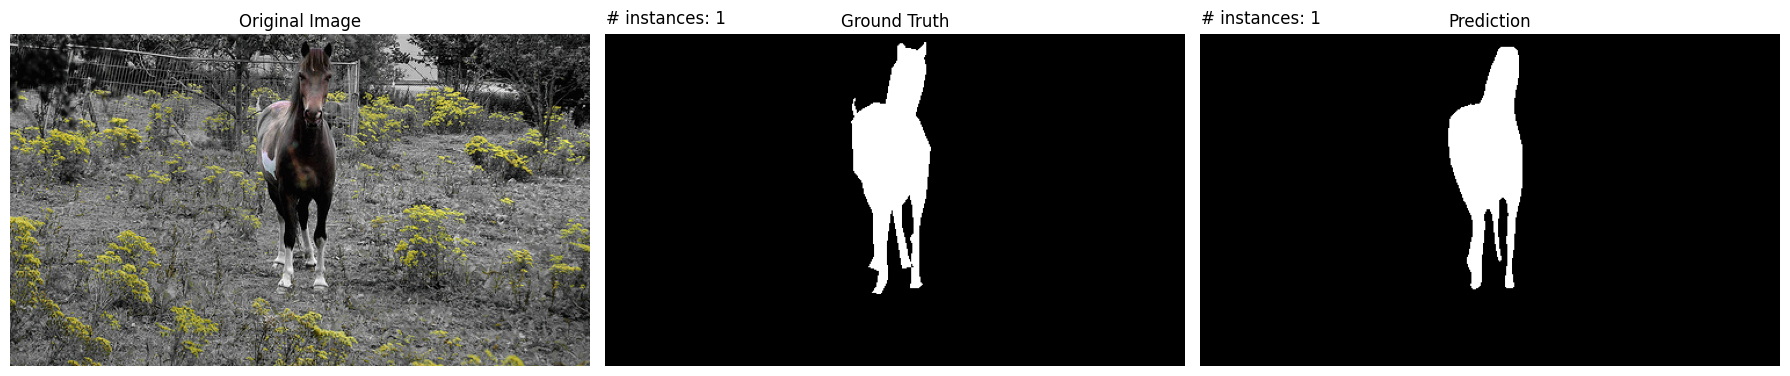

In [14]:
for i, (imgs, targets) in enumerate(data_loader):
    imgs = list(img.to(device) for img in imgs)
    for j in range(len(imgs)):
        with torch.no_grad():
            outputs = model(imgs)
        plot_predictions_vs_targets(imgs[j], outputs[j], targets[j])

    if i == 4:
        break  # visualize only a few examples